In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
import matplotlib.pyplot as plt
from math import sin, cos
plt.style.use('ggplot')
from tqdm.notebook import tqdm
import scipy.integrate as integrate
import warnings
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# Part 1

In [2]:
def plot_all(model, sol):
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))
    t = sol.x
    S = sol.y[0]
    I = sol.y[1]
    psi1 = sol.y[2]
    psi2 = sol.y[3]

    axes[0, 0].plot(t, psi1)
    axes[0, 0].set_xlabel('t'); axes[0, 0].set_ylabel('$\psi_1$')
    axes[0, 1].plot(t, psi2)
    axes[0, 1].set_xlabel('t'); axes[0, 1].set_ylabel('$\psi_2$')
    
    axes[1, 0].plot(S, psi1)
    axes[1, 0].set_xlabel('S'); axes[1, 0].set_ylabel('$\psi_1$')
    axes[1, 0].plot(S, model.alpha[3] - 2 * model.alpha[0] * model.umax[0] / S)
    axes[1, 0].plot(S, model.alpha[3] * np.ones(S.size))
    axes[1, 0].legend(['$\psi_1$', 'border', 'alpha_4'])

    axes[1, 1].plot(I, psi2) 
    axes[1, 1].set_xlabel('I'); axes[1, 1].set_ylabel('$\psi_2$')
    axes[1, 1].plot(I, model.alpha[3] - 2 * model.alpha[1] * model.umax[1] / I)
    axes[1, 1].plot(I, model.alpha[3] * np.ones(I.size))
    axes[1, 1].legend(['$\psi_2$', 'border', 'alpha_4'])
    
    axes[2, 0].plot(t, S)
    axes[2, 0].set_xlabel('t'); axes[2, 0].set_ylabel('S')
    axes[2, 1].plot(t, I)
    axes[2, 1].set_xlabel('t'); axes[2, 1].set_ylabel('I')
    
    axes[3, 0].plot(t, u1(model, S, psi1))
    axes[3, 0].set_xlabel('t'); axes[3, 0].set_ylabel('$u_1$')
    axes[3, 1].plot(t, u2(model, I, psi2))
    axes[3, 1].set_xlabel('t'); axes[3, 1].set_ylabel('$u_2$')
    
    fig.tight_layout()
    fig.suptitle("S - число индивидуумов, восприимчивых к инфекции \
                  I - число инфицированных людей", fontsize=16,  y=1.05)
    

In [3]:
class Solution:
    def __init__(self, sol):
        self.x = sol.x
        self.y = sol.y

    def __init__(self, sol1, sol2):
        self.x = np.hstack((sol1.x, sol2.x))
        print((sol1.y).shape)
        print((sol2.y).shape)
        self.y = np.hstack((sol1.y, sol2.y))

In [4]:
def u1(model, S, psi1):
    u = np.amin([model.umax[0] * np.ones(S.size), S * (model.alpha[3] - psi1) / 2 / model.alpha[0]], 0)
    return np.amax([u, np.zeros(S.size)], 0)

def u2(model, I, psi2):
    u = np.amin([model.umax[1] * np.ones(I.size), I * (model.alpha[3] - psi2) / 2 / model.alpha[1]], 0)
    return np.amax([u, np.zeros(I.size)], 0)

In [5]:
# y = [S, I, psi1, psi2]
# solve_i - i switches on trajectory
class SIR:
    def __init__(self, T=0.5, S0=100, I0=100, R0=30, beta=0.3, gamma=0.8, umax=[5, 5], alpha = [0.5, 1, 1, 3]):
        self.T = T
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.beta = beta
        self.gamma = gamma
        self.umax = umax
        self.alpha = alpha
        
        self.n_tgrid = 1000
        self.eps = 1e-3
        self.t = None
        self.sol = None
        self.Jmin = 0

    
    def J1(self, sol):
        S = sol.y[0]
        I = sol.y[1]
        psi1 = sol.y[2]
        psi2 = sol.y[3]
        
        return integrate.trapz(self.alpha[0] * self.u1(S, psi1) ** 2 \
                              + self.alpha[1] * self.u2(I, psi2) ** 2 \
                              + self.alpha[2] * self.gamma * I \
                              - self.alpha[3] * (self.u1(S, psi1) * S \
                              + self.u2(I, psi2) * I), sol.x)
    
    def solve_upd(self, sol_new):
        J_new = self.J1(sol_new)
        if J_new < self.Jmin:
            self.Jmin = J_new
            self.sol = sol_new
            
    def u1(self, S, psi1):
        u = np.amin([self.umax[0] * np.ones(S.size), S * (self.alpha[3] - psi1) / 2 / self.alpha[0]], 0)
        return np.amax([u, np.zeros(S.size)], 0)
    
    def u2(self, I, psi2):
        u = np.amin([self.umax[1] * np.ones(I.size), I * (self.alpha[3] - psi2) / 2 / self.alpha[1]], 0)
        return np.amax([u, np.zeros(I.size)], 0)


    def u1max_fun(self, S, psi1):
        return self.umax[0] * np.ones(S.size)
    
    def u2max_fun(self, I, psi2):
        return self.umax[1] * np.ones(I.size)
    
    def uZero(self, I, psi):
        return np.zeros(I.size)

    def u1_middle(self, S, psi1):
        return S * (self.alpha[3] - psi1) / 2 / self.alpha[0]
    
    def u2_middle(self, I, psi2):
        return I * (self.alpha[3] - psi2) / 2 / self.alpha[1]
    
    def fun(self, t, y, u1, u2):
        return np.vstack(( -(self.beta * y[1] + u1(y[0], y[2])) * y[0],
                          (self.beta * y[0] - (self.gamma + u2(y[1], y[3]))) * y[1],
                          u1(y[0], y[2]) * (y[2] - self.alpha[3]) + self.beta * y[1] * (y[2] - y[3]),
                          self.gamma * (self.alpha[2] + y[3]) + u2(y[1], y[3]) * (y[3] - self.alpha[3]) +\
                                + self.beta * y[0] * (y[2] - y[3]) ))
    def bc(self, ya, yb):
        return np.array([ya[0] - self.S0, ya[1] - self.I0, yb[2], yb[3]])

    def check0(self, psi):
        return np.all(psi > self.alpha[3])

    def check_max(self, psi, K, i):
        return np.all((self.alpha[3] - psi) * K >= 2 * self.alpha[i] * self.umax[i])
    
    def check_middle(self, psi, K, i):
        return np.all((self.alpha[3] - psi) * K <= 2 * self.alpha[i] * self.umax[i]) and \
               np.all(psi <= self.alpha[3])
        
    def solve0(self):
        self.t = np.linspace(0, self.T, self.n_tgrid)
        psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0
        psi20 = self.alpha[3] - 2 * self.alpha[1] * self.umax[1] / self.I0
        self.y = np.vstack((np.linspace(self.S0, 0, self.t.size), np.linspace(self.I0, 0, self.t.size),
                            np.linspace(psi10, 0, self.t.size), np.linspace(psi20, 0, self.t.size)))
        
        for i, u1 in enumerate([self.u1max_fun, self.u1_middle]):
            for j, u2 in enumerate([self.u2max_fun, self.u2_middle]):
                sol_new = solve_bvp(lambda t, y: self.fun(t, y, u1, u2),
                                    self.bc, self.t, self.y, max_nodes=1e5, tol=1e-3)
                correct_sol = True
                if i == 0:
                    correct_sol = correct_sol and self.check_max(sol_new.y[2], sol_new.y[0], 0)
                else:
                    correct_sol = correct_sol and self.check_middle(sol_new.y[2], sol_new.y[0], 0)

                if j == 0:
                    correct_sol = correct_sol and self.check_max(sol_new.y[3], sol_new.y[1], 1)
                else:
                    correct_sol = correct_sol and self.check_middle(sol_new.y[3], sol_new.y[1], 1)
                
                if correct_sol:
                    print(sol_new.status)
                    self.solve_upd(sol_new)
        return self.sol

    
    def sol_concat(self, sol1, sol2):
        sol_new = Solution()
        sol_new.x = np.hstack((sol1.x, sol2.x))
        sol_new.y = np.hstack((sol1.y, sol2.y))
        return sol_new
   
    def fun_sir(self, t, y, u1, u2):
        return np.vstack(( -(self.beta * y[1] + u1(y[0], 0)) * y[0],
                          (self.beta * y[0] - (self.gamma + u2(y[1], 0))) * y[1] ))
    
    def solve1(self):
        if self.t is None:
            self.t = np.linspace(0, self.T, self.n_tgrid)
        psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0
        psi20 = self.alpha[3] - 2 * self.alpha[1] * self.umax[1] / self.I0
        self.y = np.vstack((np.linspace(self.S0, 0, self.t.size), np.linspace(self.I0, 0, self.t.size),
                            np.linspace(psi10, 0, self.t.size), np.linspace(psi20, 0, self.t.size)))

        # SITUATION 1
        def bc11(ya, yb):
            return np.array([ya[0] - self.S0, ya[1] - self.I0])
        def bc12(ya, yb, S0, I0, psi10):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             ya[2] - psi10,
                             yb[3]])
    
        def bc112(ya, yb, S0, I0, psi10, psi20):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             yb[2] - psi10,
                             yb[3] - psi20])
        n_oc = [50 * i for i in range(1, self.n_tgrid // 50)]
        for i in n_oc:
            tau = self.t[i]
            sol_part1_sir = solve_bvp(lambda t, y: self.fun_sir(t, y, self.u1max_fun, self.u2max_fun),
                                  bc11, self.t[:i], self.y[:2, :i], max_nodes=1e5, tol=1e-3)
            if sol_part1_sir.status != 0:
                    break
            S_oc, I_oc = sol_part1_sir.sol(tau)
            psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / S_oc
            
            sz = self.t.size - i
            y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                            np.linspace(psi10, 0, sz), np.linspace(psi20, 0, sz)))
            sol_part2 = solve_bvp(lambda t, y: self.fun(t, y, self.u1_middle, self.u2max_fun),
                                  lambda ya, yb: bc12(ya, yb, S_oc, I_oc, psi10),
                                  self.t[i:], y, max_nodes=1e5, tol=1e-3)
            #   check psi1(T) = 0 ???
            if sol_part2.status == 0 and abs(sol_part2.y[2][-1]) < self.eps:
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1max_fun, self.u2max_fun),
                                  lambda ya, yb: bc112(ya, yb, self.S0, self.I0, psi10, sol_part2.y[3][0]),
                                  self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                sol_new = Solution(sol_part1, sol_part2)
                self.solve_upd(sol_new)
                
        # SITUATION 2
        # bc21 = bc11
        def bc22(ya, yb, S0, I0):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             yb[2],
                             ya[3] - self.alpha[3]])
        
        psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0
        for i in n_oc:
            tau = self.t[i]
            sol_part1_sir = solve_bvp(lambda t, y: self.fun_sir(t, y, self.u1max_fun, self.uZero), 
                                  bc11, self.t[:i], self.y[:2, :i], max_nodes=1e5, tol=1e-3)
            if sol_part1_sir.status != 0:
                    break
            S_oc, I_oc = sol_part1_sir.sol(tau)
            
            sz = self.t.size - i
            y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                            np.linspace(psi10, 0, sz), np.linspace(self.alpha[3], 0, sz)))
            sol_part2 = solve_bvp(lambda t, y: self.fun(t + tau, y, self.u1max_fun, self.u2_middle),
                                  lambda ya, yb: bc22(ya, yb, S_oc, I_oc), self.t[i:], y, max_nodes=1e5, tol=1e-3)
            #   check psi2(T) = 0 ???
            if sol_part2.status == 0 and abs(sol_part2.y[3][-1]) < self.eps:
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1max_fun, self.uZero),
                                  lambda ya, yb: bc112(ya, yb, self.S0, self.I0, sol_part2.y[2][0], self.alpha[3]),
                                  self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                sol_new = Solution(sol_part1, sol_part2, tau)
                self.solve_upd(sol_new)
                
        # SITUATION 3
        def bc131(ya, yb, S0, I0, psi20):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             (-yb[2] + self.alpha[3]) * yb[0] - 2 * self.alpha[0] * self.umax[0],
                             ya[3] - psi20])
        
        def bc132(ya, yb, S0, I0, psi10, psi20):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             ya[2] - psi10,
                             ya[3] - psi20])
        psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0
        for i in n_oc:
            tau = self.t[i]
            for psi2 in np.linspace(self.alpha[3] - 2 * self.alpha[1] * self.umax[1] / self.I0,  self.alpha[3], 100):
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1max_fun, self.u2_middle),
                                      lambda ya, yb: bc131(ya, yb, self.S0, self.I0, psi2),
                                      self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                if sol_part1.status != 0:
                    break
                S_oc, I_oc, psi10, psi20 = sol_part1.sol(tau)

                sz = self.t.size - i
                y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                                np.linspace(psi10, 0, sz), np.linspace(psi20, 0, sz)))
                sol_part2 = solve_bvp(lambda t, y: self.fun(t + tau, y, self.u1_middle, self.u2_middle),
                                      lambda ya, yb: bc132(ya, yb, S_oc, I_oc, psi10, psi20),
                                      self.t[i:], y, max_nodes=1e5, tol=1e-3)
                #   check psi1(T) = 0 and psi2(T) = 0 ???
                if sol_part2.status == 0 and abs(sol_part2.y[2][-1]) < self.eps and abs(sol_part2.y[3][-1]) < self.eps:
                    sol_new = Solution(sol_part1, sol_part2, tau)
                    self.solve_upd(sol_new)
        
        # SITUATION 4
        # bc142 = bc132
        def bc141(ya, yb, S0, I0, psi10, psi20):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             ya[2] - psi10,
                             yb[3] - psi20])
        psi10 = self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0
        for i in tqdm(n_oc):
            tau = self.t[i]
            for psi1 in np.linspace(self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0,  self.alpha[3], 100):
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1_middle, self.uZero),
                                      lambda ya, yb: bc141(ya, yb, self.S0, self.I0, psi1, self.alpha[3]),
                                      self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                if sol_part1.status != 0:
                    break
                S_oc, I_oc, psi10, psi20 = sol_part1.sol(tau)

                sz = self.t.size - i
                y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                                np.linspace(psi10, 0, sz), np.linspace(psi20, 0, sz)))
                sol_part2 = solve_bvp(lambda t, y: self.fun(t + tau, y, self.u1_middle, self.u2_middle),
                                      lambda ya, yb: bc132(ya, yb, S_oc, I_oc, psi10, psi20),
                                      self.t[i:], y, max_nodes=1e5, tol=1e-3)
                #   check psi1(T) = 0 and psi2(T) = 0 ???
                if sol_part2.status == 0 and abs(sol_part2.y[2][-1]) < self.eps and abs(sol_part2.y[3][-1]) < self.eps:
                    sol_new = Solution(sol_part1, sol_part2, tau)
                    self.solve_upd(sol_new)
                    
        # SITUATION 5
        # bc51 = bc11
        def bc52(ya, yb, S0, I0, psi20):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             yb[2],
                             ya[3] - psi20])
    
        # bc152 = bc112
        for i in n_oc:
            tau = self.t[i]
            sol_part1_sir = solve_bvp(lambda t, y: self.fun_sir(t, y, self.u1max_fun, self.u2max_fun),
                                  bc11, self.t[:i], self.y[:2, :i], max_nodes=1e5, tol=1e-3)
            if sol_part1_sir.status != 0:
                    break
            S_oc, I_oc = sol_part1_sir.sol(tau)
            psi20 = self.alpha[3] - 2 * self.alpha[1] * self.umax[1] / I_oc
            
            sz = self.t.size - i
            y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                            np.linspace(psi10, 0, sz), np.linspace(psi20, 0, sz)))
            sol_part2 = solve_bvp(lambda t, y: self.fun(t, y, self.u1max_fun, self.u2_middle),
                                  lambda ya, yb: bc52(ya, yb, S_oc, I_oc, psi20),
                                  self.t[i:], y, max_nodes=1e5, tol=1e-3)
            #   check psi2(T) = 0 ???
            if sol_part2.status == 0 and abs(sol_part2.y[3][-1]) < self.eps:
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1max_fun, self.u2max_fun),
                                  lambda ya, yb: bc112(ya, yb, self.S0, self.I0, sol_part2.y[2][0], psi20),
                                  self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                sol_new = Solution(sol_part1, sol_part2)
                self.solve_upd(sol_new)
                    
        # SITUATION 6
        def bc161(ya, yb, S0, I0, psi10):
            return np.array([ya[0] - S0,
                             ya[1] - I0,
                             ya[2] - psi10,
                             (-yb[3] + self.alpha[3]) * yb[1] - 2 * self.alpha[1] * self.umax[1]])
        
        # bc162 = 132
        psi20 = self.alpha[3] - 2 * self.alpha[1] * self.umax[1] / self.I0
        for i in n_oc:
            tau = self.t[i]
            for psi1 in np.linspace(self.alpha[3] - 2 * self.alpha[0] * self.umax[0] / self.S0,  self.alpha[3], 100):
                sol_part1 = solve_bvp(lambda t, y: self.fun(t, y, self.u1_middle, self.u2max_fun),
                                      lambda ya, yb: bc161(ya, yb, self.S0, self.I0, psi2),
                                      self.t[:i], self.y[:, :i], max_nodes=1e5, tol=1e-3)
                if sol_part1.status != 0:
                    break
                S_oc, I_oc, psi10, psi20 = sol_part1.sol(tau)

                sz = self.t.size - i
                y = np.vstack((np.linspace(S_oc, 0, sz), np.linspace(I_oc, 0, sz),
                                np.linspace(psi10, 0, sz), np.linspace(psi20, 0, sz)))
                sol_part2 = solve_bvp(lambda t, y: self.fun(t + tau, y, self.u1_middle, self.u2_middle),
                                      lambda ya, yb: bc132(ya, yb, S_oc, I_oc, psi10, psi20),
                                      self.t[i:], y, max_nodes=1e5, tol=1e-3)
                #   check psi1(T) = 0 and psi2(T) = 0 ???
                if sol_part2.status == 0 and abs(sol_part2.y[2][-1]) < self.eps and abs(sol_part2.y[3][-1]) < self.eps:
                    sol_new = Solution(sol_part1, sol_part2, tau)
                    self.solve_upd(sol_new)
        

        return self.sol

## Examples

C:\Users\Polina\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0
Умерло 263.27 у.е. людей
Переболело и выздоровело 450.17 у.е. людей
J = -108.89911


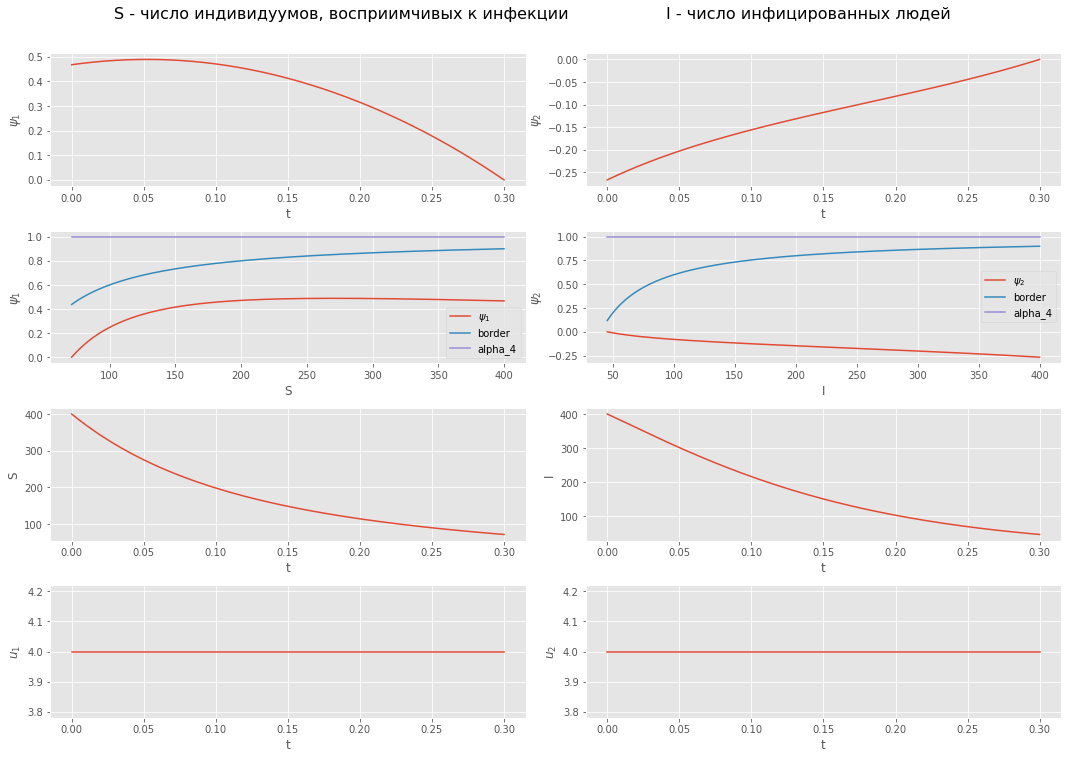

In [6]:
warnings.filterwarnings(action='once')
# solve 0 
model = SIR(T=0.3, beta=0.01, gamma=5, S0=400, I0=400, umax=[4, 4], alpha = [5, 5, 1, 1])
sol = model.solve0()
if sol is not None:
    print('Умерло %.2f у.е. людей' % integrate.trapz(model.gamma * sol.y[1], sol.x))
    print('Переболело и выздоровело %.2f у.е. людей' % (model.R0 + integrate.trapz(u1(model, sol.y[0], sol.y[2]) * sol.y[0] +\
                                                                       u2(model, sol.y[1], sol.y[3]) * sol.y[1], sol.x)))
    print('J = %.5f' % model.J1(sol))
    plot_all(model, sol)

0
Умерло 4.42 у.е. людей
Переболело и выздоровело 86.07 у.е. людей
J = -256.45626


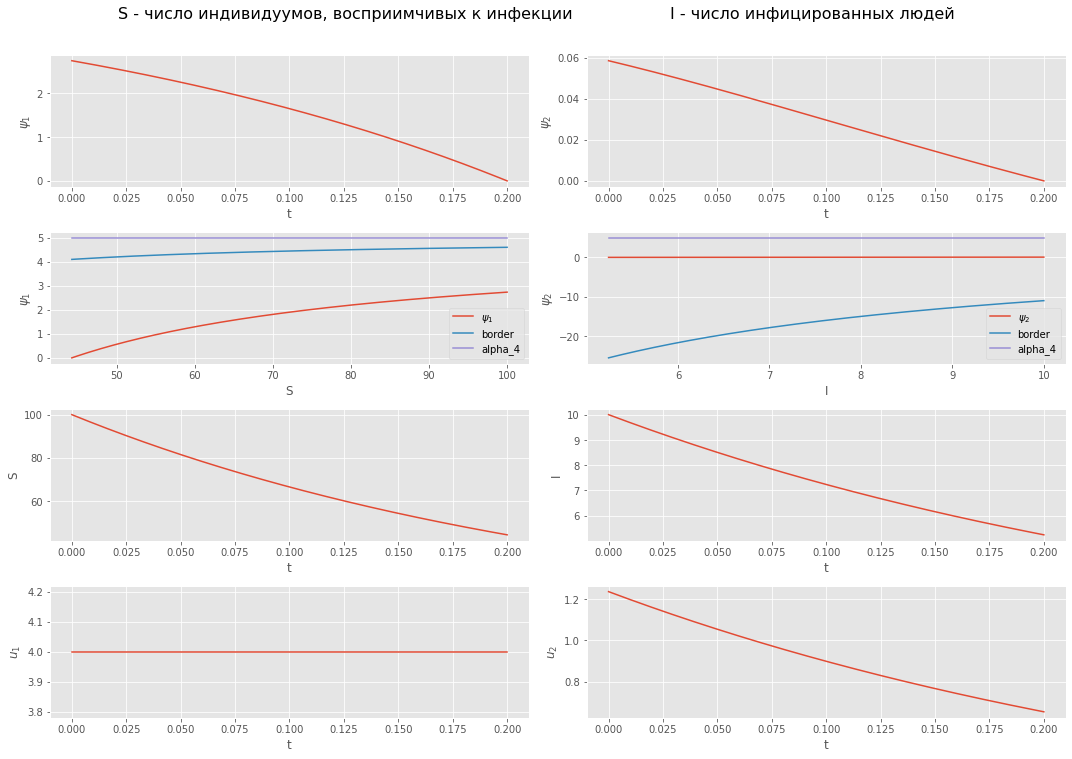

In [7]:
warnings.filterwarnings(action='once')
# solve 0 
model = SIR(T=0.2, S0=100, I0=10, R0=30, beta=0.01, gamma=3, umax=[4, 4], alpha = [5, 20, 1, 5])
sol = model.solve0()
if sol is not None:
    print('Умерло %.2f у.е. людей' % integrate.trapz(model.gamma * sol.y[1], sol.x))
    print('Переболело и выздоровело %.2f у.е. людей' % (model.R0 + integrate.trapz(u1(model, sol.y[0], sol.y[2]) * sol.y[0] +\
                                                                       u2(model, sol.y[1], sol.y[3]) * sol.y[1], sol.x)))
    print('J = %.5f' % model.J1(sol))
    plot_all(model, sol)

(4, 300)
(4, 700)



Умерло 0.29 у.е. людей
Переболело и выздоровело 33.74 у.е. людей
J = -2.66834


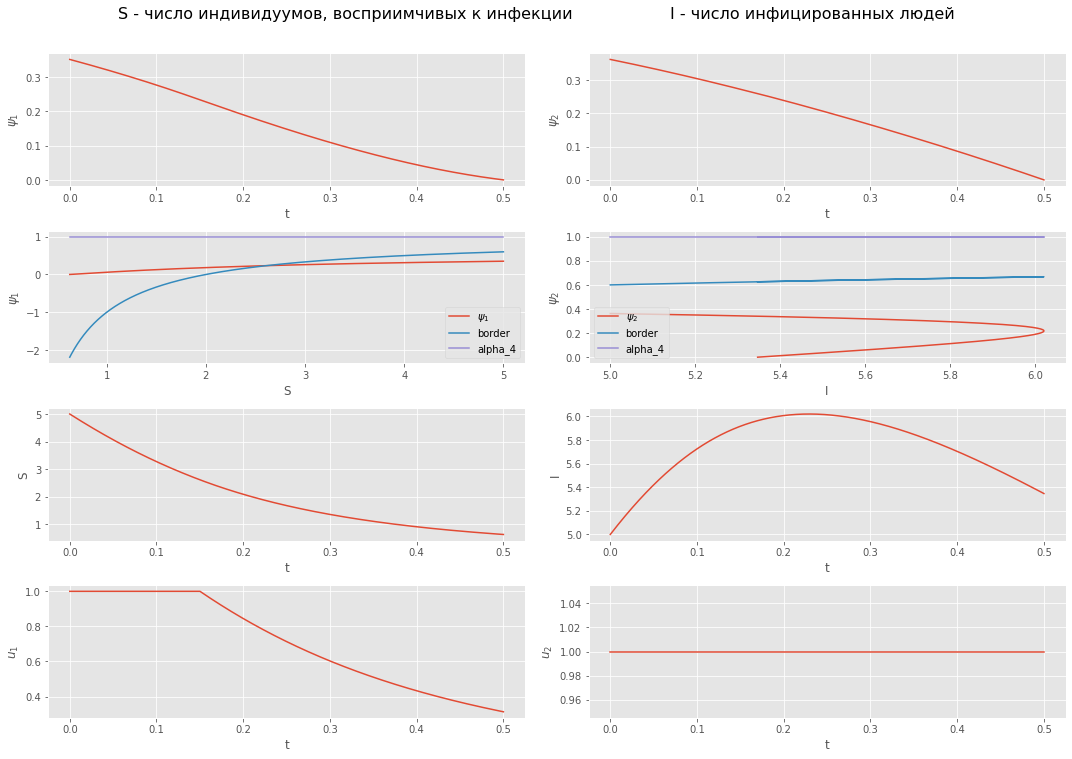

In [11]:
warnings.filterwarnings(action='once')
# solve1 
model = SIR(T=0.5, S0=5, I0=5, R0=30, beta=0.6, gamma=0.1, umax=[1, 1], alpha = [1, 1, 1, 1])

sol = model.solve1()
if sol is not None:
    print('Умерло %.2f у.е. людей' % integrate.trapz(model.gamma * sol.y[1], sol.x))
    print('Переболело и выздоровело %.2f у.е. людей' % (model.R0 + integrate.trapz(u1(model, sol.y[0], sol.y[2]) * sol.y[0] +\
                                                                       u2(model, sol.y[1], sol.y[3]) * sol.y[1], sol.x)))
    print('J = %.5f' % model.J1(sol))
    plot_all(model, sol)

# Part 2

In [12]:
def plot_all2(model, sol):
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))
    t = sol.t
    S = sol.y[0]
    I = sol.y[1]
    psi1 = sol.y[2]
    psi2 = sol.y[3]
#     u1 = sol.u1
#     u2 = sol.u2
    u1 = model.u1(sol, model.psi30)
    u2 = model.u2(sol, model.psi30)

    axes[0, 0].plot(t, psi1)
    axes[0, 0].set_xlabel('t'); axes[0, 0].set_ylabel('$\psi_1$')
    axes[0, 1].plot(t, psi2)
    axes[0, 1].set_xlabel('t'); axes[0, 1].set_ylabel('$\psi_2$')
    
    axes[1, 0].plot(S, psi1)
    axes[1, 0].set_xlabel('S'); axes[1, 0].set_ylabel('$\psi_1$')
    axes[1, 0].plot(S, model.psi30 * model.alpha[0] / S)
    axes[1, 0].legend(['$\psi_1$', 'border'])

    axes[1, 1].plot(I, psi2) 
    axes[1, 1].set_xlabel('I'); axes[1, 1].set_ylabel('$\psi_2$')
    axes[1, 1].plot(I, model.psi30 * model.alpha[1] / I)
    axes[1, 1].legend(['$\psi_2$', 'border'])
    
    axes[2, 0].plot(t, S)
    axes[2, 0].set_xlabel('t'); axes[2, 0].set_ylabel('S')
    axes[2, 1].plot(t, I)
    axes[2, 1].set_xlabel('t'); axes[2, 1].set_ylabel('I')
    
    axes[3, 0].plot(t, u1)
    axes[3, 0].set_xlabel('t'); axes[3, 0].set_ylabel('$u_1$')
    axes[3, 1].plot(t, u2)
    axes[3, 1].set_xlabel('t'); axes[3, 1].set_ylabel('$u_2$')
    
    fig.tight_layout()
    fig.suptitle("S - число индивидуумов, восприимчивых к инфекции \
                  I - число инфицированных людей", fontsize=16,  y=1.05)

<>:14: DeprecationWarning: invalid escape sequence \p


In [13]:
class Solution1:
    def __init__(self, t, y, u1, u2):
        self.t = t
        self.y = y
        self.u1 = u1
        self.u2 = u2


In [15]:
# y = [S, I, psi1, psi2]
class SIR2:
    def __init__(self, T=0.5, S0=100, I0=100, R0=30, beta=0.3, gamma=0.8, umax=[5, 5], alpha = [0.5, 1, 1, 3], M=30):
        self.T = T
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.beta = beta
        self.gamma = gamma
        self.umax = umax
        self.alpha = alpha
        self.M = M
        
        self.n_tgrid = 1000
        self.eps = 1e-3
        self.t = None
        self.sol = None
        self.Jmin = None
        self.n_psigrid = 5
    
    def J1(self, sol):
        I = sol.y[1]
        return self.gamma * integrate.trapz(I, sol.t)
    
    def solve_upd(self, sol_new, psi30):
        J_new = self.J1(sol_new)
#         print('S: ', sol_new.y[0].shape, 'I: ', sol_new.y[1].shape, 'psi1: ', sol_new.y[2].shape, 'psi2: ', sol_new.y[3].shape)
#         print(self.u1(sol_new, psi30).shape)
#         print(self.u2(sol_new, psi30).shape)
        if self.Jmin is None or J_new < self.Jmin and integrate.trapz(self.alpha[0] * self.u1(sol_new, psi30) + self.alpha[1] * self.u2(sol_new, psi30), sol_new.t) <= self.M:
#                                 integrate.trapz(self.alpha[0] * sol_new.u1 + self.alpha[1] * sol_new.u2, sol_new.t) <= self.M:
         
            
            self.Jmin = J_new
            self.sol = sol_new
            self.psi30 = psi30
    

    def u1max_fun(self, S, psi1):
        return self.umax[0] * np.ones(S.size)
    
    def u2max_fun(self, I, psi2):
        return self.umax[1] * np.ones(I.size)
    
    def uZero(self, I, psi):
        return np.zeros(I.size)
    
    def fun(self, t, y, u1, u2, psi0):
        return np.array([-(self.beta * y[1] + u1) * y[0],
                          (self.beta * y[0] - (self.gamma + u2)) * y[1],
                          u1 * y[2] + self.beta * y[1] * (y[2] - y[3]),
                          self.gamma * (-psi0 + y[3]) + u2 * y[3] +\
                                + self.beta * y[0] * (y[2] - y[3]) ])
    
    def fun_sir(self, t, y, u1, u2):
        return np.array([-(self.beta * y[1] + u1) * y[0],
                (self.beta * y[0] - (self.gamma + u2)) * y[1] ])
    
    def check_max(self, psi, K, i, psi30):
        return np.all(psi * K < self.alpha[i] * psi30)
        
    def solve0(self):
        if (self.alpha[0] * self.umax[0] + self.alpha[1] * self.umax[1]) * self.T <= self.M:
            # anormal situation
            sol_sir = solve_ivp(
                fun=lambda t, y: self.fun_sir(t, y, self.umax[0], self.umax[1]),
                t_span=(0, self.T),
                y0=[self.S0, self.I0],
                method='RK45',
                t_eval=self.t,
                max_step=1e-2 )
            
            sol_new = Solution1(sol_sir.t,
                               np.vstack((sol_sir.y, np.zeros(len(sol_sir.t)), np.zeros(len(sol_sir.t))  )),
                               np.full_like(sol_sir.t, self.umax[0]),
                               np.full_like(sol_sir.t, self.umax[1])
                               )
            self.solve_upd(sol_new, 1)
        else:
            print('For 0 переключений u1 = u2 = 0, not optimal, try more переключений')
    
        return self.sol
    
    def switch_u1(self, t, y):
        return y[0] * y[2] - self.alpha[0] * self.cur_psi30
    switch_u1.terminal = True
    
    def switch_u2(self, t, y):
        return y[1] * y[3] - self.alpha[1] * self.cur_psi30
    switch_u2.terminal = True
    
    def u1(self, sol, psi30):
        idx = np.where(sol.y[2] * sol.y[0] > self.alpha[0] * psi30)[0]
        u = np.zeros(sol.t.shape)
        for i in idx:
            u[i] = self.umax[0]
        return u
    
    def u2(self, sol, psi30):
        idx = np.where(sol.y[3] * sol.y[1] > self.alpha[1] * psi30)[0]
        u = np.zeros(sol.t.shape)
        for i in idx:
            u[i] = self.umax[1]
        return u
    
    def ivp_wrapper(self, psi0, tau, y0, cur_u1, cur_u2, max_step=np.inf):

        S = np.empty(0)
        I = np.empty(0)
        psi = np.empty((2, 0))
        u1 = np.empty(0)
        u2 = np.empty(0)
        t = np.empty(0)
        
        success = True
        niter = 0
        
        while tau < self.T:
#             print('tau ', tau)
#             print(y0)
            t_eval = np.linspace(tau, self.T, 50)
            sol = solve_ivp(
                fun=lambda t, y: self.fun(t, y, cur_u1, cur_u2, psi0),
                t_span=(tau, self.T),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
                events=(self.switch_u1, self.switch_u2),
                max_step=max_step
            )
#             print('status ', sol.status)
            
            t = np.hstack((t, sol.t))
            S = np.hstack((S, sol.y[0]))
            I = np.hstack((I, sol.y[1]))
            psi = np.hstack((psi, sol.y[2:]))
            u1 = np.hstack((u1, np.full_like(sol.t, cur_u1)))
            u2 = np.hstack((u2, np.full_like(sol.t, cur_u2)))
            
            # если сломалось интегрирование, заканчиваем 
            if sol.status < 0 or niter > 100:
                success = False
                break

            
            # если не было event'ов, заканчиваем
            if sol.status == 0:
                break
                
                
            if sol.t_events[0].size > 0:
                if sol.t_events[1].size > 0:
                    # переключение по u1
                    if sol.t_events[0][0] < sol.t_events[1][0]:
                        cur_u1 = self.umax[0] - cur_u1
                    # переключение по u2
                    elif sol.t_events[0][0] > sol.t_events[1][0]:
                        cur_u2 = self.umax[1] - cur_u2
                    else:
                        cur_u1 = self.umax[0] - cur_u1
                        cur_u2 = self.umax[1] - cur_u2
                else:
                    cur_u1 = self.umax[0] - cur_u1
            else:
                cur_u2 = self.umax[1] - cur_u2

            y0 = sol.y[:, -1]
            tau = sol.t[-1]
            
            niter += 1
        
        return success, Solution1(t,
                        np.vstack(( S, I, psi )),
                        u1, u2
                        )
    
    def solve2(self):
        
        self.t = np.linspace(0, self.T, self.n_tgrid)
        
        psi1_init_list = np.linspace(-11, 11, self.n_psigrid)
        psi2_init_list = np.linspace(-10, 10, self.n_psigrid)
        psi3_init_list = np.linspace(-12, 12, self.n_psigrid)

        u = [0, 0]
        for psi10 in tqdm(psi1_init_list):
            for psi20 in psi2_init_list:
                for psi30 in psi3_init_list:
                    self.cur_psi30 = psi30
                    if psi10 * self.S0 > self.alpha[0] * psi30:
                        u[0] = 0
                    else:
                        u[0] = self.umax[0]
                        
                    if psi20 * self.I0 > self.alpha[1] * psi30:
                        u[1] = 0
                    else:
                        u[1] = self.umax[1]
#                     print(self.alpha[0] * psi30 / self.S0, psi10, u[0], self.alpha[1] * psi30 / self.I0, psi20, u[1])

                    success, sol_new = self.ivp_wrapper(psi0=-1,
                                                    tau=0,
                                                    y0=np.array([self.S0, self.I0, psi10, psi20]),
                                                    cur_u1=u[0], cur_u2=u[1],
                                                    max_step=1e-2)

                    if success:
                        if abs(sol_new.t[-1] - self.T) > 1e-2:
                            print(sol_new.t[-1])
                        if abs(sol_new.y[2][-1]) < 1e-3 and abs(sol_new.y[3][-1]) < 1e-3:
                            self.solve_upd(sol_new, psi30)

        return self.sol
    
    def solve1(self, y0=None):
        self.t = np.linspace(0, self.T, self.n_tgrid)

        def bc1(ya, yb, psi10, psi30):
            return np.array([ya[0] - self.S0,
                             ya[1] - self.I0,
                             ya[2] - psi10,
                             yb[3] * yb[1] - self.alpha[1] * psi30] )
        
        def bc2(ya, yb, psi20, psi30):
            return np.array([ya[0] - self.S0,
                             ya[1] - self.I0,
                             yb[2] * yb[0] - self.alpha[0] * psi30,
                             ya[3] - psi20])
        
        bc = [bc1, bc2]
        bcSI = [self.S0, self.I0]
        # 1м переключился psi_i
        n_oc = [50 * i for i in range(1, self.n_tgrid // 50)]
        for teta in tqdm(np.linspace(np.pi / 2, np.pi, self.n_psigrid)):
            for fi in np.linspace(-np.pi / 2, np.pi / 2, self.n_psigrid):
                self.cur_psi30 = 5 * sin(teta) * cos(fi)
                psi_i1 = 5 * sin(teta) * sin(fi)
#                 psi00 = 5 * cos(fi)
                for psi00 in [5 * cos(teta), -5 * cos(teta)]:
                    for idx_psi in range(2):

                        # self.t[n_oc] - время переключения по psi2
                        for i in n_oc:
                            if y0 is None:
                                y0 = np.vstack((np.linspace(self.S0, 0, i), np.linspace(self.I0, 0, i),
                                        np.linspace(psi_i1, 0, i), np.linspace(psi_i1, 0, i)))

                            u = [0, 0]
                            if psi_i1 * bcSI[idx_psi] > self.alpha[idx_psi] * self.cur_psi30:
                                u[idx_psi] = 0
                            else:
                                u[idx_psi] = self.umax[idx_psi]

                            # попробуем 2 варианта: переключение с 0 на umax[i_psi] и наоборот
                            for u_ in [0, self.umax[1 - idx_psi]]:
                                u[1 - idx_psi] = u_
                                sol_part1_wout_u = solve_bvp(lambda t, y: self.fun(t, y, u[0], u[1], psi00),
                                                    lambda ya, yb: bc[idx_psi](ya, yb, psi_i1, self.cur_psi30),
                                                    self.t[:i], y0[:, :i], max_nodes=1e5, tol=1e-3)

                                if sol_part1_wout_u.status == 0:
#                                     print("GO TO PART 2")
                                    sol_part1 = Solution1(sol_part1_wout_u.x,
                                                     sol_part1_wout_u.y,
                                                     u[0], u[1]
                                                     )
                                    # check, что по psi1 не переключались
                                    if np.all(sol_part1.y[2 + idx_psi] * bcSI[idx_psi] > self.alpha[idx_psi] * self.cur_psi30) or \
                                        np.all(sol_part1.y[2 + idx_psi] * bcSI[idx_psi] > self.alpha[idx_psi] * self.cur_psi30):
                                        ### отпускаем в свободное плавание дальше
                                        success, sol_part2 = self.ivp_wrapper(psi00,
                                                                        self.t[i],
                                                                        np.array(sol_part1.y[:, -1]),
                                                                        u[0], u[1],
                                                                        np.inf)
#                                         print(self.t[i], sol_part2.y.shape)

                                        if success:
                                            sol_new = Solution1(np.hstack((sol_part1.t, sol_part2.t)),
                                                               np.hstack((sol_part1.y, sol_part2.y)),
                                                               np.hstack((sol_part1.u1, sol_part2.u1)),
                                                               np.hstack((sol_part1.u2, sol_part2.u2)))
#                                             print('T shape ', sol_new.t.shape, 'u shape ', sol_new.y.shape)
                                            self.solve_upd(sol_new, self.cur_psi30)
    
        return self.sol


## Examples

Умерло 8.63 людей
Переболело и выздоровело 5.05 у.е. людей
J = 8.63055
Wall time: 887 ms


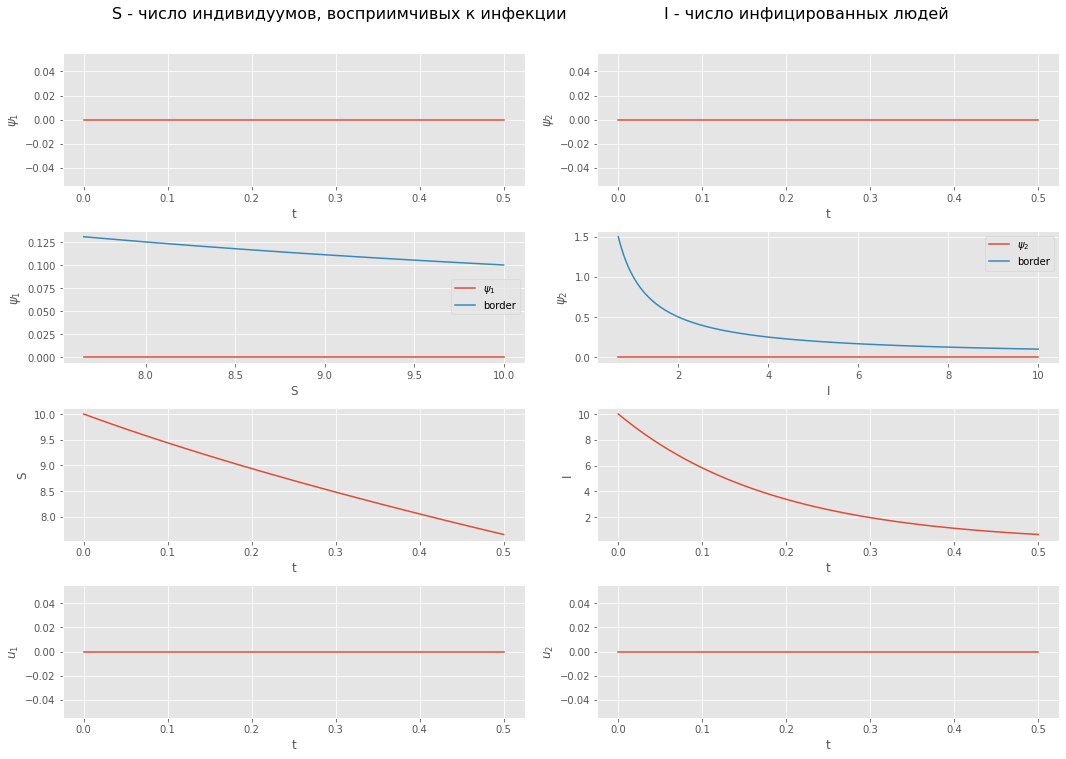

In [17]:
%%time
model = SIR2(T=0.5, S0=10, I0=10, R0=2, beta=0.01, gamma=5, umax=[0.5, 0.5], alpha = [1, 1], M = 2)
sol = model.solve0()
if sol is not None:
    print('Умерло %.2f людей' % integrate.trapz(model.gamma * sol.y[1], sol.t))
    print('Переболело и выздоровело %.2f у.е. людей' % (model.R0 + integrate.trapz(sol.u1 * sol.y[0] +\
                                                                       sol.u2 * sol.y[1], sol.t)))
    print('J = %.5f' % model.J1(sol))
    plot_all2(model, sol)

В качестве начального приближения берем точку, куда приехала 1 модель:

0



Умерло 3.49 у.е. людей
Переболело и выздоровело 109.57 у.е. людей
J = 3.49285


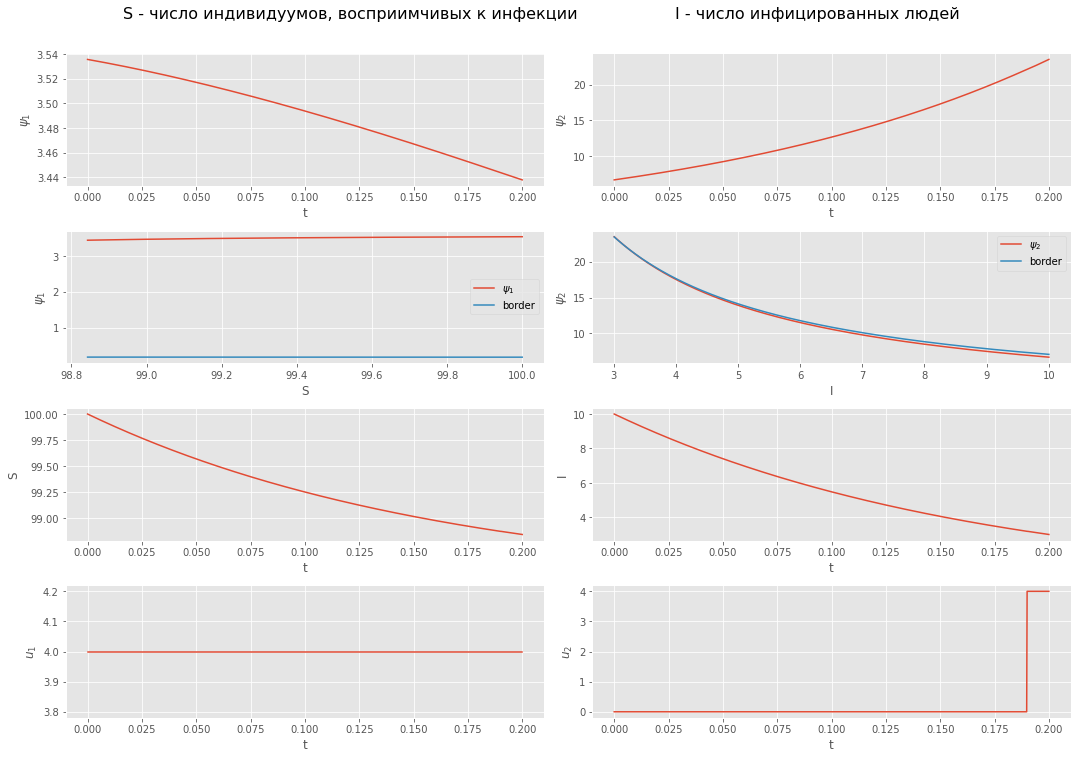

In [16]:
warnings.filterwarnings(action='once')
# solve 0 
model = SIR(T=0.2, S0=100, I0=10, R0=30, beta=0.01, gamma=3, umax=[4, 4], alpha = [5, 20, 1, 5])
sol = model.solve0()
model2 = SIR2(T=0.2, S0=100, I0=10, R0=30, beta=0.01, gamma=3, umax=[4, 4], alpha = [5, 20, 1, 5])

sol2 = model2.solve1(sol.y)
if sol2 is not None:
    print('Умерло %.2f у.е. людей' % integrate.trapz(model2.gamma * sol2.y[1], sol2.t))
    print('Переболело и выздоровело %.2f у.е. людей' % (model2.R0 + integrate.trapz(model2.u1(sol2, model2.psi30) * sol2.y[0] +\
                                                                       model2.u2(sol2, model2.psi30) * sol2.y[1], sol2.t)))
    print('J = %.5f' % model2.J1(sol2))
    plot_all2(model2, sol2)

(4, 300)
(4, 700)



Умерло 0.30 у.е. людей
Переболело и выздоровело 34.07 у.е. людей
J = 0.30056


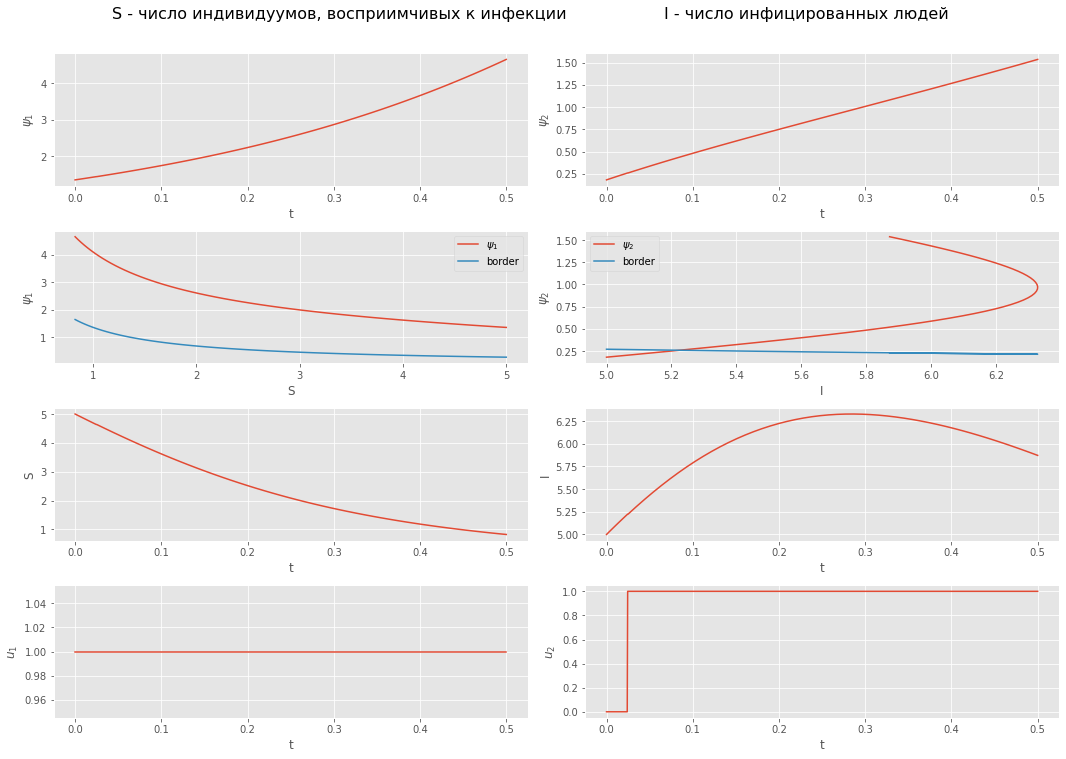

In [20]:
warnings.filterwarnings(action='once')
# solve1 
model = SIR(T=0.5, S0=5, I0=5, R0=30, beta=0.6, gamma=0.1, umax=[1, 1], alpha = [1, 1, 1, 1])
sol = model.solve1()
model = SIR2(T=0.5, S0=5, I0=5, R0=30, beta=0.6, gamma=0.1, umax=[1, 1], alpha = [1, 1, 1, 1])
sol2 = model.solve1(sol.y)
if sol2 is not None:
    print('Умерло %.2f у.е. людей' % integrate.trapz(model.gamma * sol2.y[1], sol2.t))
    print('Переболело и выздоровело %.2f у.е. людей' % (model.R0 + integrate.trapz(model.u1(sol2, model.psi30) * sol2.y[0] +\
                                                                       model.u2(sol2, model.psi30) * sol2.y[1], sol2.t)))
    print('J = %.5f' % model.J1(sol2))
    plot_all2(model, sol2)